* Entities - names of products, services, individuals, events, 
and organizations
* Aspects – the attributes and components of entities

Example - The iPhone’s call quality is good, but its battery life is short
1. Entities = iPhone
2. Aspects = call quality, battery life
3. Opinion = good, short

3 Techniques to get aspects and opinions:

1. By finding frequent nouns and noun phrases.
2. By exploiting syntactic relations.
3. Using supervised learning.

## Import Libraries

In [ ]:
!pip install vaderSentiment
!pip install squarify

In [ ]:
import spacy
import numpy as np
from spacy import displacy
import pickle as pk
from os import getcwd
import pandas as pd
import json
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import squarify
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import operator

## Technique 1 - By exploiting syntactic relations

These sample reviews were extracted from Yelp for a Chinese restaurant (only 21 of them for illustration).

In [ ]:
# replace the file path with one appropriate for your drive
df_reviews = pd.read_csv('Reviews_DTF.txt', sep = '\t', names=["reviews"])
df_reviews

,reviews
0,I love this place. I visit this place (or one ...
1,"Must try: xiao long bao, chili crab bun, fried..."
2,Highly recommend trying the chili sauce also. ...
3,For those who are not familiar with asian food...
4,This Din Tai Fung is located on the 4th floor ...
5,The staff at the entrance gave me a number and...
6,Staffs were all friendly and attentive. I like...
7,FOOD 4/5 The legendary xiao long bao (steamed ...
8,AMBIENCE 3/5 It was noisy but I did not expect...
9,"STAFFS 5/5 Staffs were attentive, helpful and ..."


In [ ]:
# !python -m spacy download en_core_web_sm
nlp = spacy.load('en_core_web_sm')

In [ ]:
# let's pick a review
eg=0
print(df_reviews["reviews"][eg])

# process it using spacy
doc = nlp(df_reviews["reviews"][eg])
for idno, sentence in enumerate(doc.sents):
  print('Sentence {}:'.format(idno + 1), sentence)

I love this place. I visit this place (or one of the other din tai fung outlets) at least once a month. 
Sentence 1: I love this place.
Sentence 2: I visit this place (or one of the other din tai fung outlets) at least once a month.


A review has one or more sentences. It's often assumed that a sentence has one target and one sentiment, but it's not always like that.
Let's take look at the dependency information sentence by sentence.

In [ ]:
# ROOT is usually associated to key verb in the sentence.
# "I -- nsubj -- love VERB" means I is the noun subject of verb love.
# We are interested in nsubj,obj,iobj,nmod,amod dependencies to get the aspect and opinion.

for sent in doc.sents:
  print ("*"*100)
  for token in sent:
    print(token.text, '--', # token (also called dependent)
          token.dep_, '--', # dependency of token with head
          token.head.text,  # head (also called governor)
          token.head.pos_,  # POS of head
          [child for child in token.children]) # if given token is itself the head of other tokens, those other tokens are considered children

****************************************************************************************************
I -- nsubj -- love VERB []
love -- ROOT -- love VERB [I, place, .]
this -- det -- place NOUN []
place -- dobj -- love VERB [this]
. -- punct -- love VERB []
****************************************************************************************************
I -- nsubj -- visit VERB []
visit -- ROOT -- visit VERB [I, place, once, .]
this -- det -- place NOUN []
place -- dobj -- visit VERB [this, (, or, one]
( -- punct -- place NOUN []
or -- cc -- place NOUN []
one -- conj -- place NOUN [of, )]
of -- prep -- one NUM [din]
the -- det -- din NOUN []
other -- amod -- din NOUN []
din -- pobj -- of ADP [the, other, outlets]
tai -- compound -- outlets NOUN []
fung -- compound -- outlets NOUN []
outlets -- appos -- din NOUN [tai, fung]
) -- punct -- one NUM []
at -- advmod -- least ADJ []
least -- advmod -- once ADV [at]
once -- advmod -- visit VERB [least, month]
a -- det -- month NOUN []
month

In [ ]:
# visualize the dependencies.
displacy.render(doc.sents, style='dep', jupyter=True, options = {'distance':80})

Let's look at the breakdown of a sentence in detail. In this sentence, where is the root of the sentence, where everything is joined together? However, it is possible that sometimes due to the sentence structure there may be no root in the results.
We can filter for specific dependencies in the result.

In [ ]:
def getDep(sentence, rel):
    deps=[]
    print("Input sentence is: " + str(sentence))
    print('-'*50)

    for tok in sentence:
        dep =  (tok.text, tok.dep_, "---> ", tok.head.text)
        print(dep)
        deps.append(dep)

    result = list(filter(lambda x : x[1]==rel or x[1].find(rel)!=-1, deps))

    if len(result) == 0:
      return 999

    return result

In [ ]:
# let's extract the obj relation from a sentence

sentence = "John likes big apple."
found = getDep(nlp(sentence), "obj")
print("The result is :" + str(found))

Input sentence is: John likes big apple.
--------------------------------------------------
('John', 'nsubj', '---> ', 'likes')
('likes', 'ROOT', '---> ', 'likes')
('big', 'amod', '---> ', 'apple')
('apple', 'dobj', '---> ', 'likes')
('.', 'punct', '---> ', 'likes')
The result is :[('apple', 'dobj', '---> ', 'likes')]


We can also use the dependency information to extract 'triples'. The predicate can come from the root or a clause without its own object/subject. The noun subject would be 'nsubj', and the object usually follow as 'dobj'. Putting it altogether, and we get a triple.

In [ ]:
def getTriple(sentence):
    deps=[]
    print("Input sentence is: " + str(sentence))
    print('-'*50)

    for tok in sentence:  
        dep =  (tok.text, tok.dep_, "---> ", tok.head.text)
        deps.append(dep)

    subj = list(filter(lambda x : x[1]=="nsubj", deps))
    obj = list(filter(lambda x : x[1]=="dobj", deps))
    root = list(filter(lambda x : x[1]=="ROOT" , deps))

    try: 
        triple = (subj[0][0], root[0][0], obj[0][0])
        print(subj)
        print(obj)
        print(root)
        return triple

    except IndexError:
        print ("Pattern incorrect. No triples for " + str(sentence)) # rules needed to be written to extract some triples
        return None

In [ ]:
triples=[]
s = "John likes big apple. The apple tastes delicious."

#doing it sentence by sentence
for sentence in nlp(s).sents:
  triple = getTriple(sentence)  # obtain triples in that sentence
  print ("Triple is " + str(triple))
  triples.append(triple)
  print('*'*100)

Input sentence is: John likes big apple.
--------------------------------------------------
[('John', 'nsubj', '---> ', 'likes')]
[('apple', 'dobj', '---> ', 'likes')]
[('likes', 'ROOT', '---> ', 'likes')]
Triple is ('John', 'likes', 'apple')
****************************************************************************************************
Input sentence is: The apple tastes delicious.
--------------------------------------------------
Pattern incorrect. No triples for The apple tastes delicious.
Triple is None
****************************************************************************************************


## Technique 2 - By finding frequent nouns and noun phrases


* Find nouns and noun phrases using a POS tagger
* Count their occurrence frequencies
* Keep only the frequent ones above a experimentally 
determined threshold

In [ ]:
l=[]
for sentence in df_reviews["reviews"]:
  doc = nlp(sentence)
  for i in doc.sents:
    for tok in i:
      if(tok.is_alpha==True and tok.is_stop==False and tok.pos_=='NOUN'):
        l.append(tok.text.lower())
d = dict(Counter(l))
print(dict(sorted(d.items(), key=operator.itemgetter(1),reverse=True)))

In [ ]:
c=0
for i in list(df_reviews['text']):
  if(i.lower().find('seat')!= -1):
    print(i)
    c=c+1
    if(c==10):
      break

In [ ]:
# Prepare a mapping function
# Get list for each category using Frequency approach (if a word has high frequency, then it is possibly an entity/aspect)
# Define categories manually = food, service and price

aspect = {"food": ["xiao long bao", "noodles", "food", "dumplings", "pork", "flavour", "chili", 
                   "dishes", "lunch", "bun", "shrimp", "dimsum", "rice", "chicken"],
        "service" : ["staff", "wait", "water", "queue" ],
        "price" : ["price", "cost"]  }

In [ ]:
# Classify each sentence into the given 3 categories
# Use a category 'overall' to cover all other sentences   

def aspectCat(sentence):
    category=[]
    for tok in sentence:
        tok = tok.text.lower()
        for key, val in aspect.items():
            if tok in val: category.append(key)
    if len(category) == 0 : category.append("overall")
    return category

Till now we have mapped a category (entity/aspect) to every sentence. We still need to give a sentiment to the aspect. Next, we'll use Vader to do sentiment classification of sentences.

In [ ]:
analyzer = SentimentIntensityAnalyzer()

In [ ]:
# Vader returns 4 scores. We take the 'compound' score as overall sentiment for the sentence.
res = analyzer.polarity_scores("but the price is expensive.")
res

{'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0}

Given a review, for each sentence, we get its sentiment score and aspect category.

In [ ]:
def getSentiment(span):
  res = analyzer.polarity_scores(span.text)
  senti = np.round(res['compound'],2)
  return (senti)

In [ ]:
result_sents =[] 
ex=0
doc = nlp(df_reviews["reviews"][ex])

for idx, sentence in enumerate(doc.sents):
  res = getSentiment(sentence)

  try:
    cat = aspectCat(sentence)      
    result_sents.append({"scores":res, "text":sentence, "category":cat})

  except IndexError:
    result_sents.append({"scores":res, "text":sentence, "category":"overall"})

for s in result_sents:
  print(s)

{'scores': 0.64, 'text': I love this place., 'category': ['overall']}
{'scores': 0.0, 'text': I visit this place (or one of the other din tai fung outlets) at least once a month., 'category': ['overall']}


Let's do it for the whole set of reviews and do a summarisation. 

In [ ]:
reviews = {}
for i in range(len(df_reviews["reviews"])):
  doc = nlp(df_reviews["reviews"][i])
  review_sents =[] 
  for idx, sentence in enumerate(doc.sents):
    res = getSentiment(sentence)

    try:
      cat = aspectCat(sentence)      
      review_sents.append({"scores":res, "text":sentence.text, "category":cat})

    except IndexError:
      review_sents.append({"scores":res, "text":sentence.text, "category":"overall"})

  reviews[i]=review_sents

reviews

{0: [{'category': ['overall'], 'scores': 0.64, 'text': 'I love this place.'},
  {'category': ['overall'],
   'scores': 0.0,
   'text': 'I visit this place (or one of the other din tai fung outlets) at least once a month.'}],
 1: [{'category': ['food', 'food', 'food', 'food', 'food'],
   'scores': 0.0,
   'text': 'Must try: xiao long bao, chili crab bun, fried rice with pork, braised beef noodles.'}],
 2: [{'category': ['food'],
   'scores': 0.42,
   'text': 'Highly recommend trying the chili sauce also.'},
  {'category': ['service'],
   'scores': 0.47,
   'text': 'This place can get crowded, so i recommend that you get a queue number early.'},
  {'category': ['overall'],
   'scores': -0.04,
   'text': 'No reservations unfortunately.'}],
 3: [{'category': ['food', 'food', 'food'],
   'scores': 0.61,
   'text': 'For those who are not familiar with asian food, I recommend that your group orders a number of dishes and shares everything (asian way) rather than each person ordering your own 

In [ ]:
# summarise all reviews
summary_scores = {"overall":[], "service":[], "price":[], "food":[]}

# count total no of 
for key,value in reviews.items():
  for ResultList in value:
    score = ResultList["scores"]
    for CatList in ResultList["category"]:
      summary_scores[CatList].append(score)

# for each category, summarize how many reviews are positive, negative respectively
summary_scores

{'food': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.42,
  0.61,
  0.61,
  0.61,
  0.0,
  0.0,
  0.0,
  0.0,
  0.48,
  0.0,
  0.0,
  0.71,
  0.56,
  0.32,
  0.32,
  0.61,
  0.64,
  0.42,
  0.53,
  0.53,
  0.0,
  0.03,
  0.62,
  0.0,
  0.48,
  0.48,
  0.72,
  0.48,
  0.77,
  -0.08,
  -0.08,
  0.79,
  0.79,
  0.74,
  0.74,
  -0.48,
  -0.08,
  0.0,
  0.27,
  0.56,
  0.0],
 'overall': [0.64,
  0.0,
  -0.04,
  0.42,
  0.44,
  -0.34,
  0.49,
  0.36,
  0.82,
  0.88,
  0.3,
  0.0,
  0.59,
  0.0,
  -0.18,
  0.45,
  0.0,
  0.42,
  0.44,
  0.42,
  0.25,
  0.0,
  0.79,
  0.93,
  0.36,
  0.62,
  0.0,
  0.0,
  0.0,
  0.46,
  0.0,
  0.64,
  0.64,
  0.0,
  -0.18,
  0.0,
  0.59],
 'price': [0.42, 0.62, 0.27],
 'service': [0.47, 0.08, 0.43, 0.0, 0.0]}

In [ ]:
for key, val in summary_scores.items():

    #avg = round(np.mean(val),2)
    pos = np.sum(np.array(val) >= 0, axis=0)
    neg = np.sum(np.array(val) < 0, axis=0)

    summary_scores[key]={"pos":pos,"neg": neg}

summary_scores

{'food': {'neg': 4, 'pos': 42},
 'overall': {'neg': 4, 'pos': 33},
 'price': {'neg': 0, 'pos': 3},
 'service': {'neg': 0, 'pos': 5}}

In [ ]:
df_summary = pd.DataFrame(summary_scores)
df_summary

,overall,service,price,food
pos,33,5,3,42
neg,4,0,0,4


In [ ]:
df_summary = df_summary.transpose()
df_summary

,pos,neg
overall,33,4
service,5,0
price,3,0
food,42,4


In [ ]:
# Represent overall sentiment for the categary, sentiment score = (Pos-Neg)/Total
# sentiment score <1 means neg>0 (there is some negativity in the reviews)
Diff = df_summary["pos"]-df_summary["neg"]
Total = df_summary["neg"]+df_summary["pos"]
df_summary["sentiment"] = np.round((Diff/Total),2)
df_summary

,pos,neg,sentiment
overall,33,4,0.78
service,5,0,1.00
price,3,0,1.00
food,42,4,0.83


Treemap for Visualization

In [ ]:
# For each category we produce a square
# Size of the square = how many sentences are there (larger square means more sentences are there for that category)
# Color of the square = overall sentiment (darker means more positive)

Text(0.5, 1.0, 'Sentiment Heat Map of Restaurant Aspects')

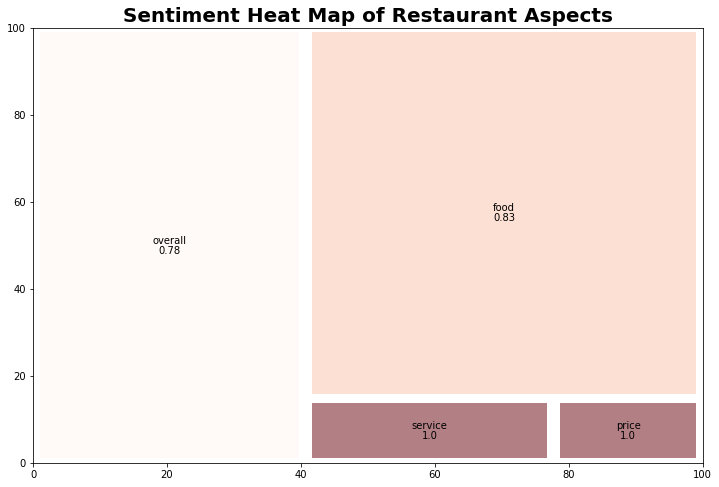

In [ ]:
norm = matplotlib.colors.Normalize(vmin=min(df_summary['sentiment']), vmax=max(df_summary['sentiment']))
colors = [matplotlib.cm.Reds(norm(value)) for value in df_summary['sentiment']]

fig = plt.gcf()
fig.set_size_inches(12, 8)

squarify.plot(label=df_summary.index,
              sizes=Total, 
              value = df_summary['sentiment'],
              color = colors, 
              alpha=.5, 
              pad =True)

plt.title("Sentiment Heat Map of Restaurant Aspects",fontsize=20,fontweight="bold")

### Conclusion
This example illustrates how the reviews are categorised and sentiment classified based on 3 aspect categories - food, price and service, with the rest as overall.

There are many ways to improve on it. This includes:
 - using lemmatization to identify mapped words
 - integrating with consistuency parsing to obtain NP chunks
 - using customized sentiment classifier
 - using co-reference resolution. The latter is useful as many of the pronouns like 'it', 'they'  have no identified targets in the subsequent sentences. They should similarly be mapped to the relevant entities and aspects.

### Exercise

- Perform the same exercise on another set of data - this time for rows of the airline sentiment data. What are the difficulties that you face? What aspects (and groups) do you consider in this case (heuristically)?